# Getting started with Thinc Framework

This example shows how to get started with Thinc, using the "hello world" of neural network models: recognizing handwritten digits from the [MNIST dataset](http://yann.lecun.com/exdb/mnist/).


This notebook covers:
- building and visualizing a simple model
- using the config system, and
- training the model



In [1]:
!pip install ml_datasets "tqdm>=4.41"

`prefer_gpu` function make sure we're performing operations on GPU if it is available. 

The function should be called right after importing Thinc, and it returns a boolean indicating whether the GPU has been activated.

If GPU is not available or not properly setup, the code will still work, just slower :)


In [2]:
from thinc.api import prefer_gpu
prefer_gpu()

False

In [3]:
import matplotlib.pyplot as plt
import ml_datasets
from tqdm.notebook import tqdm
from thinc.api import Adam, fix_random_seed


## Some utility functions


In [4]:
def train_model(data, model, optimizer, n_iter, batch_size):
    (train_X, train_Y), (test_X, test_Y) = data
    for i in range(n_iter):
        batches = model.ops.multibatch(batch_size, train_X, train_Y, shuffle=True)
        for X, Y in tqdm(batches, leave=False):
            Yh, backprop = model.begin_update(X)
            backprop(Yh - Y)
            model.finish_update(optimizer)
        # Evaluate and print progress
        correct = 0
        total = 0
        for X, Y in model.ops.multibatch(batch_size, test_X, test_Y):
            Yh = model.predict(X)
            correct += (Yh.argmax(axis=1) == Y.argmax(axis=1)).sum()
            total += Yh.shape[0]
        score = correct / total
        print(f" {i} {float(score):.3f}")

def plot_image(data, img_index):
    # y_train contains the lables, ranging from 0 to 9
    img = data[img_index].reshape(28, 28)
    plt.imshow(img, cmap = 'gray')


# Prepare the dataset

The `ml_datasets` package already packs MNIST dataset properly formated and splitted in training and test tuples.
Thus, we only have to retrieve it and store in variables to be used.

Each tuple is comprised of **features** and **target** elements, both are numpy arrays.


In [5]:
(train_X, train_Y), (test_X, test_Y) = ml_datasets.mnist()

In [7]:
print(f"Training size={len(train_X)}, dev size={len(test_X)}")
print("train_X shape:", train_X.shape, "train_Y shape:", train_Y.shape)
# Print the number of training, validation, and test datasets
print(train_X.shape[0], 'train set')
print(test_X.shape[0], 'test set')

Training size=54000, dev size=10000
train_X shape: (54000, 784) train_Y shape: (54000, 10)
54000 train set
10000 test set


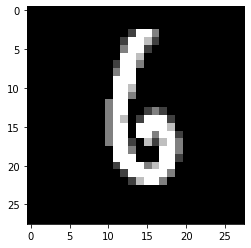

In [9]:
# Image index, you can pick any number between 0 and 59,999
plot_image(train_X, img_index=103)


# Model

Let’s use the following network architecture:

- Two Relu-activated hidden layers, 
- Add dropout after the two hidden layers (to help the model generalize better),
- A softmax-activated output layer. 

The chain combinator is like `Sequential` in PyTorch or Keras: it combines a list of layers together with a feed-forward relationship.

Observe that when we **defined the model**, we don’t inform the input or the output sizes. This is inferred by the framework.


In [10]:
from thinc.api import chain, Relu, Softmax
 
n_hidden = 32
dropout = 0.2

model = chain(
    Relu(nO=n_hidden, dropout=dropout), 
    Relu(nO=n_hidden, dropout=dropout), 
    Softmax()
)

### Visualization

If you want visualize the model, run the cells in this session.

Make sure you have GraphViz installed and properly configured in your system if you want to visualize the model.

on MacOS:

```
brew install graphviz
```


In [11]:

!pip install pydot graphviz svgwrite

import pydot
from IPython.display import SVG, display

def get_label(layer):
    layer_name = layer.name
    nO = layer.get_dim("nO") if layer.has_dim("nO") else "?"
    nI = layer.get_dim("nI") if layer.has_dim("nI") else "?"
    return f"{layer.name}|({nI}, {nO})".replace(">", "&gt;")

def visualize_model(model):
    dot = pydot.Dot()
    dot.set("rankdir", "LR")
    dot.set_node_defaults(shape="record", fontname="arial", fontsize="10")
    dot.set_edge_defaults(arrowsize="0.7")
    nodes = {}
    for i, layer in enumerate(model.layers):
        label = get_label(layer)
        node = pydot.Node(layer.id, label=label)
        dot.add_node(node)
        nodes[layer.id] = node
        if i == 0:
            continue
        from_node = nodes[model.layers[i - 1].id]
        to_node = nodes[layer.id]
        if not dot.get_edge(from_node, to_node):
            dot.add_edge(pydot.Edge(from_node, to_node))
    display(SVG(dot.create_svg()))



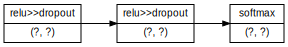

In [12]:
# Before initialization. Check the layers parameters
visualize_model(model)

After creating the model, we can call the `Model.initialize` method, passing in a small batch of input data `X` and a small batch of output data `Y`. This allows Thinc to infer the missing dimensions.

NOTE!
We need, however, make sure the data is on the **right device** when passing in the data. This is done by calling `model.ops.asarray` which will e.g. transform the arrays to cupy when running on GPU.

In [13]:
# making sure the data is on the right device, 
# converting them to cupy (if we're using that)
# model.ops.xp is an instance of either numpy or cupy, 
# depending on whether you run the code on CPU or GPU.
train_X = model.ops.asarray(train_X)
train_Y = model.ops.asarray(train_Y)
test_X = model.ops.asarray(test_X)
test_Y = model.ops.asarray(test_Y)

model.initialize(X=train_X[:5], Y=train_Y[:5])
nI = model.get_dim("nI")
nO = model.get_dim("nO")
print(f"Initialized model with input dimension nI={nI} and output dimension nO={nO}")

Initialized model with input dimension nI=784 and output dimension nO=10


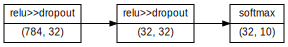

In [14]:
# After initialization. Check the layers parameters. 
# Dimention inference from data is playing here.
visualize_model(model)

### Training the model



In [15]:
fix_random_seed(0)
optimizer = Adam(0.001)
batch_size = 128
print("Measuring performance across iterations:")

data = (train_X, train_Y), (test_X, test_Y)
train_model(data, model, optimizer, 10, batch_size)


Measuring performance across iterations:


0 0.851


1 0.887


2 0.902


3 0.909


4 0.919


5 0.918


6 0.924


7 0.925


8 0.927


9 0.930


# Define the model based on configuration

Here's a config describing the model we defined above. The values in the `hyper_params` section can be referenced in other sections to keep them consistent. The `*` is used for **positional arguments** – in this case, the arguments to the `chain` function, two Relu layers and one softmax layer.

In [16]:
from thinc.api import Config, registry

CONFIG = """
[hyper_params]
n_hidden = 32
dropout = 0.2
learn_rate = 0.001

[model]
@layers = "chain.v1"

[model.*.relu1]
@layers = "Relu.v1"
nO = ${hyper_params:n_hidden}
dropout = ${hyper_params:dropout}

[model.*.relu2]
@layers = "Relu.v1"
nO = ${hyper_params:n_hidden}
dropout = ${hyper_params:dropout}

[model.*.softmax]
@layers = "Softmax.v1"

[optimizer]
@optimizers = "Adam.v1"
learn_rate = ${hyper_params:learn_rate}

[training]
n_iter = 10
batch_size = 128
"""

config = Config().from_str(CONFIG)
config

{'hyper_params': {'n_hidden': 32, 'dropout': 0.2, 'learn_rate': 0.001},
 'model': {'@layers': 'chain.v1',
  '*': {'relu1': {'@layers': 'Relu.v1', 'nO': 32, 'dropout': 0.2},
   'relu2': {'@layers': 'Relu.v1', 'nO': 32, 'dropout': 0.2},
   'softmax': {'@layers': 'Softmax.v1'}}},
 'optimizer': {'@optimizers': 'Adam.v1', 'learn_rate': 0.001},
 'training': {'n_iter': 10, 'batch_size': 128}}

When you call `registry.make_from_config`, Thinc will first create the three layers using the specified arguments populated by the hyperparameters. It will then pass the return values (the layer objects) to `chain`. It will also create an optimizer. All other values, like the training config, will be passed through as a regular dict. 

If you want to change a hyperparameter or experiment with a different optimizer, all you need to change is the config. For each experiment you run, you can save a config and you'll be able to reproduce it later.

Your training code can now look like this:

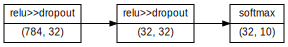

In [17]:
loaded_config = registry.make_from_config(config)
model = loaded_config["model"]
model.initialize(X=train_X[:5], Y=train_Y[:5])
visualize_model(model)


In [18]:
optimizer = loaded_config["optimizer"]
n_iter = loaded_config["training"]["n_iter"]
batch_size = loaded_config["training"]["batch_size"]

train_model(data, model, optimizer, n_iter, batch_size)

0 0.851


1 0.883


2 0.898


3 0.905


4 0.915


5 0.914


6 0.922


7 0.925


8 0.927


9 0.929
